### CSV test

In [1]:
import pandas as pd
bird_results = pd.read_csv('logs_merged.csv')
bird_results.head(2)


,Unnamed: 0,question,gold_query,db_id,final_query,schema_linking,classification,sql_generation,self_correction
0,0,What is the highest eligible free rate for K-1...,SELECT `FRPM Count (K-12)` / `Enrollment (K-12...,california_schools,"SELECT frpm.""FRPM Count (K-12)"" / frpm.""Enroll...","""highest eligible free rate"" so we need column...",The SQL query for the given question needs the...,"For creating the SQL for the given question, w...","1) The column `MAX(frpm.""FRPM Count (K-12)"") /..."
1,1,Please list the lowest three eligible free rat...,SELECT `Free Meal Count (Ages 5-17)` / `Enroll...,california_schools,"SELECT frpm.""Free Meal Count (Ages 5-17)"" / fr...","""lowest three eligible free rates"" so we need ...",The SQL query for the given question needs the...,"For creating the SQL for the given question, w...","1) The column ""School Name"" is not mentioned i..."


In [2]:
bird_results.size

12726

### Plots

In [15]:
data ={
    'Name': ['Zero-Shot (GPT-3.5)','Few-Shot (GPT-3.5)','DIN-SQL (GPT-3.5)',"Zero-Shot (GPT-4)"],
    'Iteration 1': [37.14, 36.19, 40.57, 38.09],
    'Iteration 2': [45.28, 50, 50.94, 55.66]
}
df = pd.DataFrame(data)


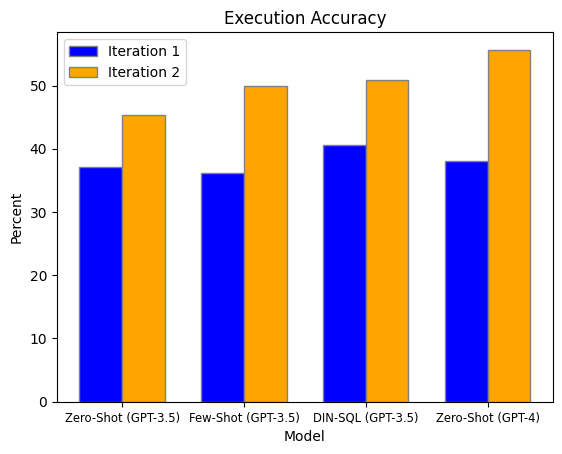

In [16]:
import matplotlib.pyplot as plt
import numpy as np
 
# Set the width of the bars
barWidth = 0.35


# Set position of bar on X axis
r1 = np.arange(len(df['Iteration 1']))
r2 = [x + barWidth for x in r1]

# Make the plot
plt.bar(r1, df['Iteration 1'], color='b', width=barWidth, edgecolor='grey', label='Iteration 1')
plt.bar(r2, df['Iteration 2'], color='orange', width=barWidth, edgecolor='grey', label='Iteration 2')

# Add xticks on the middle of the group bars
plt.xlabel('Model')
plt.xticks([r + barWidth/2 for r in range(len(df['Iteration 1']))], df['Name'], fontsize='small')

#y-axis
plt.ylabel('Percent')
# Create legend & Show graphic
plt.legend()
plt.title('Execution Accuracy')
plt.show()


In [5]:
import sqlite3
import os
from collections import Counter

class DatabaseInterface():

    DEV_DB_PATH = os.path.abspath(
      os.path.join(os.getcwd(), '..', 'data/BIRD/dev/dev_databases/'))
   
    TRAIN_DB_PATH = os.path.abspath(
      os.path.join(os.getcwd(), '..', 'data/BIRD/train/train_databases/'))

    def __init__(self):
      self.conn = None
      self.cursor = None
      self.data = []

      self.current_db = ""
      self.current_database_schema = ""

      self.load_database_names()


    def execute_queries_and_match_data(self, sql: str, gold_sql: str, db_name: str) -> int:
        """
        Execute provided SQL queries and compare the results.

        Parameters:
            sql (str): The predicted SQL query to execute.
            gold_sql (str): The golden SQL query to compare results.
            db_name (str): The database name on which the queries will be executed.

        Returns:
            int: 1 if the results match, otherwise 0.
        """

        if self.current_db != db_name:
            self.load_db(db_name)
        
        try:            
            self.cursor.execute(sql)
            pred_res = self.cursor.fetchall()                
        except sqlite3.Error as err:            
            return 0

        try:
          self.cursor.execute(gold_sql)
          golden_res = self.cursor.fetchall()
        except sqlite3.Error as err:            
          return 0

        equal = (Counter(pred_res) == Counter(golden_res))
        return int(equal)
    
    def load_db(self, db_name: str) -> None:
      """
      Load a database into the class by connecting and setting a cursor.

      Parameters:
         db_name (str): The name of the database to load.
      """
      db_path = ""
      if db_name in self.dev_databases:
         db_path = f"{self.DEV_DB_PATH}/{db_name}/{db_name}.sqlite"
      else:
         db_path = f"{self.TRAIN_DB_PATH}/{db_name}/{db_name}.sqlite"
         
      self.conn = sqlite3.connect(db_path)      
      self.cursor = self.conn.cursor()
      self.current_db = db_name

    
    def load_database_names(self):
      self.dev_databases = os.listdir(self.DEV_DB_PATH)
      self.train_databases = os.listdir(self.TRAIN_DB_PATH)
   

In [28]:
import pandas as pd


df = pd.read_csv('logs_merged.csv')
db = DatabaseInterface()

total_successes = 0
total_successes_per_domain = {}
total_questions_per_domain = {}

for index, row in df.iterrows():
    
    gold_query = row['gold_query']
    predicted_query = row['final_query']
    db_id = row['db_id']

    success = db.execute_queries_and_match_data(predicted_query, gold_query, db_id)
    total_successes += success

    if not db_id in total_successes_per_domain:
        total_successes_per_domain[db_id] = success
    else:
        total_successes_per_domain[db_id] += success

    if not db_id in total_questions_per_domain:
        total_questions_per_domain[db_id] = 1
    else:
        total_questions_per_domain[db_id] += 1

    if index % 100 == 0:
        print("At row: " + str(index) + " Total successes: " + str(total_successes))



At row: 0 Total successes: 0
At row: 100 Total successes: 53
At row: 200 Total successes: 117
At row: 300 Total successes: 172
At row: 400 Total successes: 205
At row: 500 Total successes: 232
At row: 600 Total successes: 268
At row: 700 Total successes: 285
At row: 800 Total successes: 318
At row: 900 Total successes: 354
At row: 1000 Total successes: 381
At row: 1100 Total successes: 413
At row: 1200 Total successes: 443
At row: 1300 Total successes: 475
At row: 1400 Total successes: 517


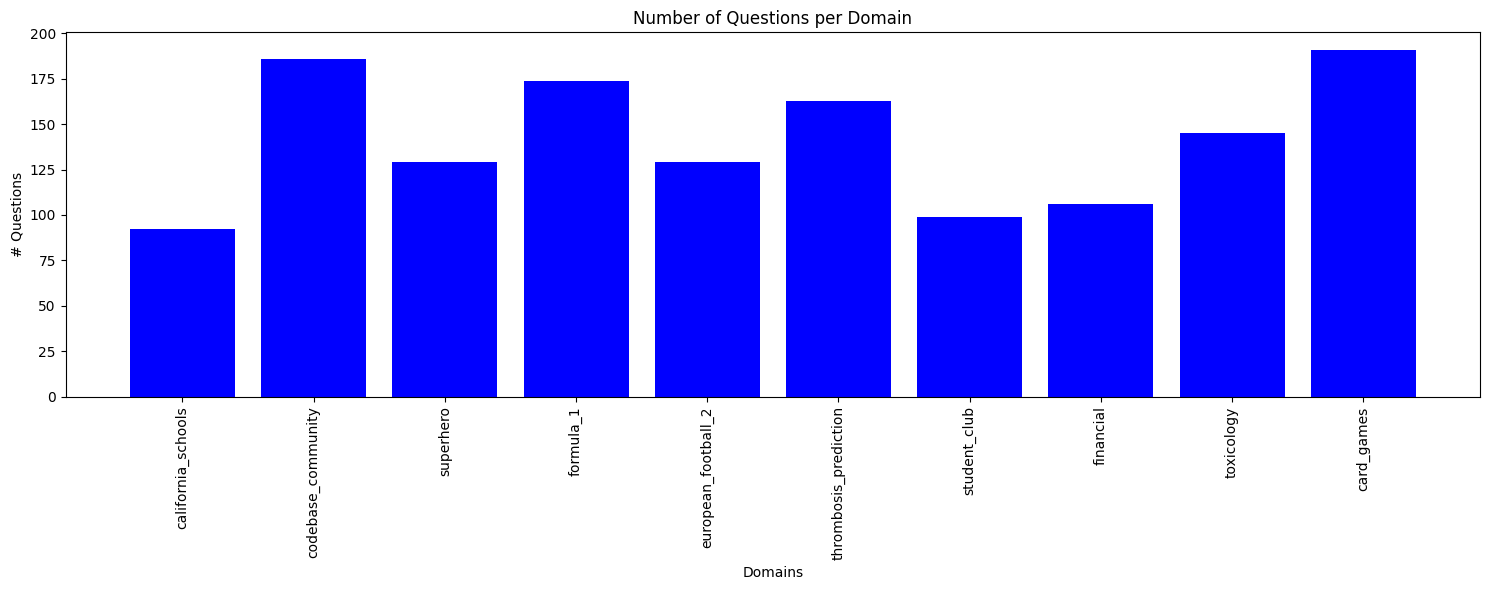

In [43]:
import matplotlib.pyplot as plt

# Creating a bar plot
plt.figure(figsize=(15, 6))  # Adjust the figure size as needed
plt.bar(total_questions_per_domain.keys(), total_questions_per_domain.values(), color='blue')
plt.xlabel('Domains')
plt.ylabel('# Questions')
plt.title('Number of Questions per Domain')
plt.xticks(rotation=90)  # Rotate the domain names for better readability
plt.tight_layout()  # Adjust layout to fit everything nicely

plt.show()

In [37]:
for key in total_questions_per_domain:
    print(key + ": " + str(total_questions_per_domain[key]))

california_schools: 92
codebase_community: 186
superhero: 129
formula_1: 174
european_football_2: 129
thrombosis_prediction: 163
student_club: 99
financial: 106
toxicology: 145
card_games: 191


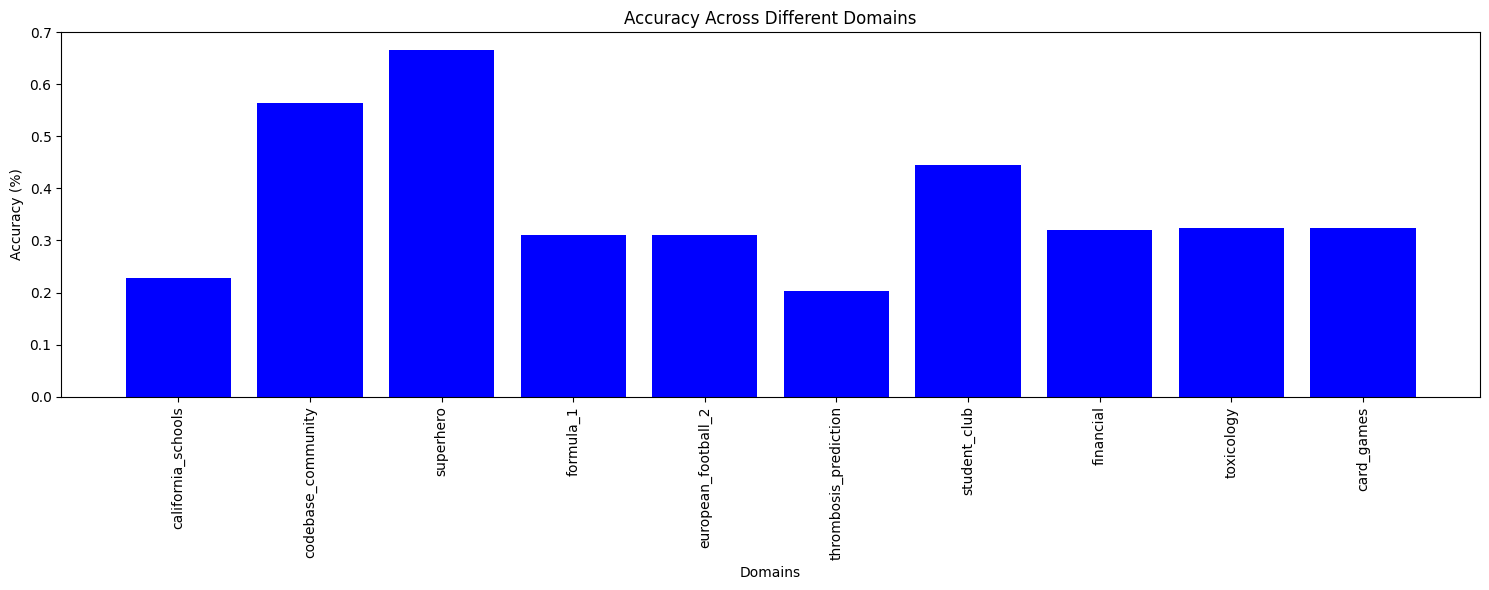

In [35]:
import matplotlib.pyplot as plt


accuracies = [x/y for x,y in zip(total_successes_per_domain.values(), total_questions_per_domain.values())]

# Creating a bar plot
plt.figure(figsize=(15, 6))  # Adjust the figure size as needed
plt.bar(total_questions_per_domain.keys(), accuracies, color='blue')
plt.xlabel('Domains')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Across Different Domains')
plt.xticks(rotation=90)  # Rotate the domain names for better readability
plt.tight_layout()  # Adjust layout to fit everything nicely

plt.show()

In [46]:
domain_accuracies = zip(total_questions_per_domain.keys(), accuracies)

for key in domain_accuracies:    
    print(key[0] + ": " + str(key[1]))



california_schools: 0.22826086956521738
codebase_community: 0.5645161290322581
superhero: 0.6666666666666666
formula_1: 0.3103448275862069
european_football_2: 0.31007751937984496
thrombosis_prediction: 0.20245398773006135
student_club: 0.4444444444444444
financial: 0.32075471698113206
toxicology: 0.32413793103448274
card_games: 0.32460732984293195


In [58]:
domain_accuracies = zip(total_questions_per_domain.keys(), accuracies)
total_acc = 0
for domain in domain_accuracies:
    total_acc += domain[1]


print("Mean accuracy: " + str(total_acc / len(total_questions_per_domain.values())))
print("Finance domain: 0.32075471698113206")

Mean accuracy: 0.3696264422263247
Finance domain: 0.32075471698113206
